In [1]:
import chromatix.functional as cf
import jax.numpy as jnp
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

In [42]:
# Settings
shape = (16, 16)
spacing = 0.25
wavelength = 1.0

In [43]:
# Making a chromatix field
field = cf.plane_wave(
            shape=shape,
            dx=spacing,
            spectrum=wavelength,
            amplitude=cf.linear(0.0),
        )

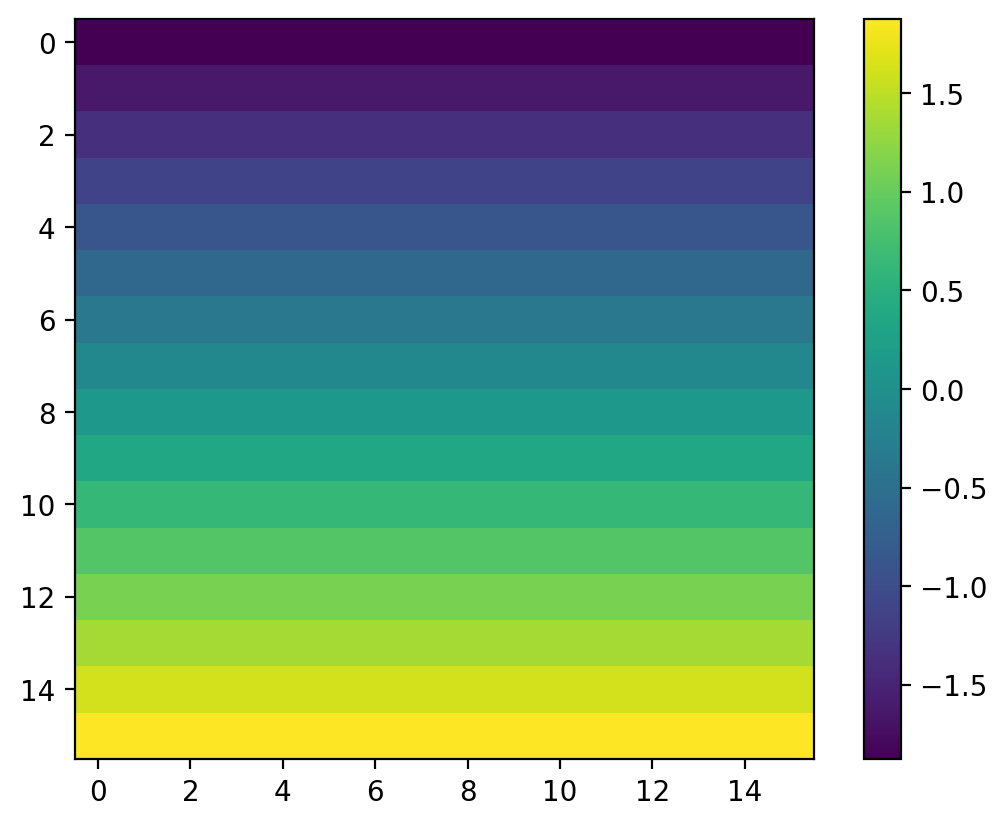

In [44]:
# Observation 1) y needs to be inverted!
plt.imshow(field.grid[0].squeeze())
plt.colorbar()

In [45]:
# so chromatix has a centered grid
field.grid[0, 0, :, 0, 0, 0]

Array([-1.875     , -1.625     , -1.375     , -1.125     , -0.875     ,
       -0.6249999 , -0.37499988, -0.12499988,  0.12500012,  0.37500012,
        0.6250001 ,  0.8750002 ,  1.1250002 ,  1.3750002 ,  1.6250002 ,
        1.875     ], dtype=float32)

In [51]:
# And the corresponding k-grid
field.k_grid[0, 0, :, 0, 0, 0]

Array([-1.875     , -1.625     , -1.375     , -1.125     , -0.875     ,
       -0.6249999 , -0.37499988, -0.12499988,  0.12500012,  0.37500012,
        0.6250001 ,  0.8750002 ,  1.1250002 ,  1.3750002 ,  1.6250002 ,
        1.875     ], dtype=float32)

In [52]:
# This is what it should be for the k-grid
jnp.fft.fftshift(jnp.fft.fftfreq(shape[0], spacing))

Array([-2.  , -1.75, -1.5 , -1.25, -1.  , -0.75, -0.5 , -0.25,  0.  ,
        0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75], dtype=float32)

In [55]:
# We can easily fix this by adding half a spacing
dk = jnp.diff(field.k_grid[0, 0, :, 0, 0, 0])[0]
field.k_grid[0, 0, :, 0, 0, 0] - 1/2 * dk

Array([-2.0000000e+00, -1.7500000e+00, -1.5000000e+00, -1.2500000e+00,
       -1.0000000e+00, -7.4999988e-01, -4.9999988e-01, -2.4999988e-01,
        1.1920929e-07,  2.5000012e-01,  5.0000012e-01,  7.5000018e-01,
        1.0000002e+00,  1.2500002e+00,  1.5000002e+00,  1.7500000e+00],      dtype=float32)

In [8]:
# And in this case the grid, to be aligned with fourier space should be this:
jnp.linspace(0, (shape[0] - 1) * spacing, shape[0]) - (shape[0] * spacing) / 2

Array([-2.  , -1.75, -1.5 , -1.25, -1.  , -0.75, -0.5 , -0.25,  0.  ,
        0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75], dtype=float32)

# Comparing this to chromatix

In [59]:
# Let's do a propagation in chromatix with the old coordinates
shape = (512, 512)
spacing = 0.25
wavelength = 1.0

field = cf.plane_wave(
        shape=shape,
        dx=spacing,
        spectrum=wavelength,
        amplitude=cf.linear(0.0),
        pupil=cf.tukey(20),
    )
field = cf.transfer_propagate(field, 1000, 1.0, shape[0]//2, mode="full")

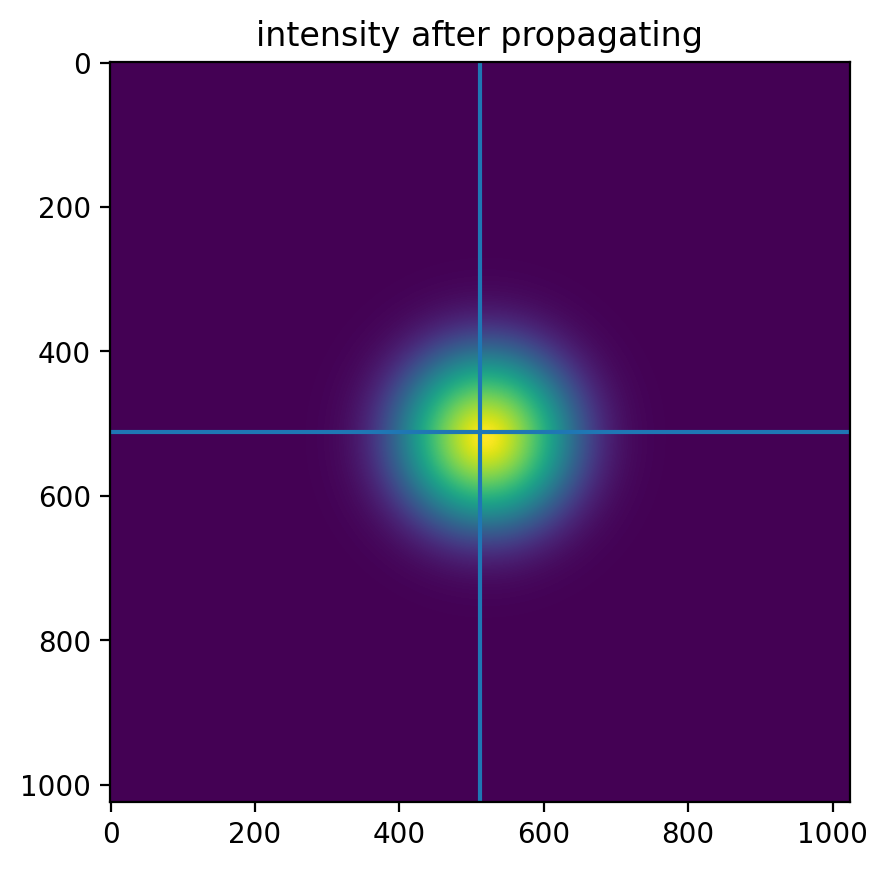

In [60]:
plt.title("intensity after propagating")
plt.imshow(field.intensity.squeeze())
plt.axhline(512)
plt.axvline(512)


In [61]:
# Argmax is at 519 - definitely not a one-off error!
jnp.where(field.intensity == jnp.max(field.intensity))

(Array([0], dtype=int32),
 Array([519], dtype=int32),
 Array([519], dtype=int32),
 Array([0], dtype=int32),
 Array([0], dtype=int32))

In [68]:
# What if we do it with the fixed coordinates?
from chromatix import Field, ScalarField, VectorField
from chromatix.typing import ArrayLike, ScalarLike
from typing import Literal
from jax import Array
from chromatix.field import crop, pad
from chromatix.utils import _broadcast_1d_to_grid, _broadcast_1d_to_innermost_batch, l2_sq_norm
from chromatix.functional.propagation import kernel_propagate

def transfer_propagate(
    field: Field,
    z: ScalarLike,
    n: ScalarLike,
    N_pad: int,
    cval: float = 0,
    absorbing_boundary: Literal["tukey", "super_gaussian"] | None = None,
    absorbing_boundary_width: float = 0.65,
    kykx: ArrayLike | tuple[float, float] = (0.0, 0.0),
    mode: Literal["full", "same"] = "full",
) -> Field:
    
    field = pad(field, N_pad, cval=cval)
    propagator = compute_transfer_propagator(field, z, n, kykx)
    field = kernel_propagate(
        field, propagator, absorbing_boundary, absorbing_boundary_width
    )
    if mode == "same":
        field = crop(field, N_pad)
    return field
    
def compute_transfer_propagator(
    field: ScalarField | VectorField,
    z: ScalarLike,
    n: ScalarLike,
    kykx: ArrayLike | tuple[float, float] = (0.0, 0.0),
) -> Array:
    kykx = _broadcast_1d_to_grid(kykx, field.ndim)
    z = _broadcast_1d_to_innermost_batch(z, field.ndim)

    # Instead of field.k_grid we make our own
    k_grid = field.k_grid - 1/2 * field.dk
    phase = -jnp.pi * (field.spectrum / n) * z * l2_sq_norm(k_grid - kykx)
    return jnp.fft.ifftshift(jnp.exp(1j * phase), axes=field.spatial_dims)

field = cf.plane_wave(
        shape=shape,
        dx=spacing,
        spectrum=wavelength,
        amplitude=cf.linear(0.0),
        pupil=cf.tukey(20),
    )
field = transfer_propagate(field, 1000, 1.0, shape[0]//2, mode="full")

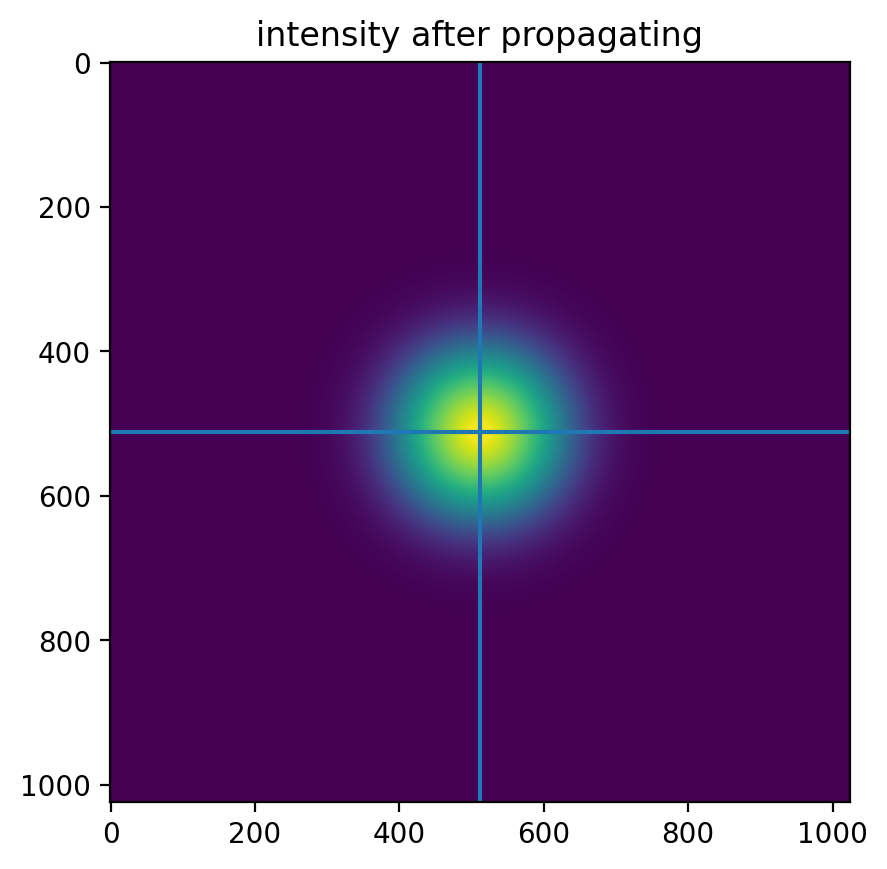

In [69]:
plt.title("intensity after propagating")
plt.imshow(field.intensity.squeeze())
plt.axhline(512)
plt.axvline(512)


In [70]:
# Argmax is at 512 - correct!
jnp.where(field.intensity == jnp.max(field.intensity))

(Array([0, 0, 0], dtype=int32),
 Array([511, 512, 512], dtype=int32),
 Array([512, 511, 512], dtype=int32),
 Array([0, 0, 0], dtype=int32),
 Array([0, 0, 0], dtype=int32))

# New making grid functions

In [ ]:
jnp.fft.fftshift(jnp.fft.fftfreq(shape[0], spacing))